In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()
from matplotlib.pyplot import rc_context

Memory usage: current 0.22 GB, difference +0.22 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [4]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [5]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [6]:
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [7]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [8]:
obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]

In [9]:
# Perform a left join
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")

# Update the adata.obs with the new annotations
adata.obs = updated_obs


In [10]:
# Combine AML cells into one type
adata.obs["cell_type_aml"] = adata.obs["cell_type_sub_prolif_anno"].copy()
adata.obs["cell_type_aml"] = adata.obs["cell_type_aml"].apply(
    lambda x: "AML cells" if str(x).startswith("AML cells") else x)
adata.obs["cell_type_aml"] = pd.Categorical(adata.obs["cell_type_aml"])




In [11]:
#find non abund genes
E = sc.pp.normalize_per_cell(adata.layers["counts"], counts_per_cell_after = 1e4, copy = True)
######min_cells = 5, min_counts = 10######
# Filtering "noisy" genes
gmask = filter_abund_genes(E = E, min_cells = 5, min_counts = 10)

print(len(adata[:, gmask].var_names))
print(len(adata.var_names))
abund_genes = list(adata[:, gmask].var_names)



20609 genes passing abundance filter
20609
37733


In [12]:
print(len(adata))
adata = adata[:, gmask]
print(len(adata))

86447
86447


In [13]:
# DGE AML cells (combined) vs rest

sc.tl.rank_genes_groups(adata, "cell_type_aml", groups=["AML cells"], reference = "rest", method = "wilcoxon", use_raw = False)

ranking genes


/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (0:02:00)


In [14]:
rank_genes_groups = adata.uns['rank_genes_groups']
# Save the dictionary to a file
filename = "backups/aml_cells_vs_all_other_cells_%s.pkl"%(now())

with open(filename, "wb") as f:
    pickle.dump(rank_genes_groups, f)


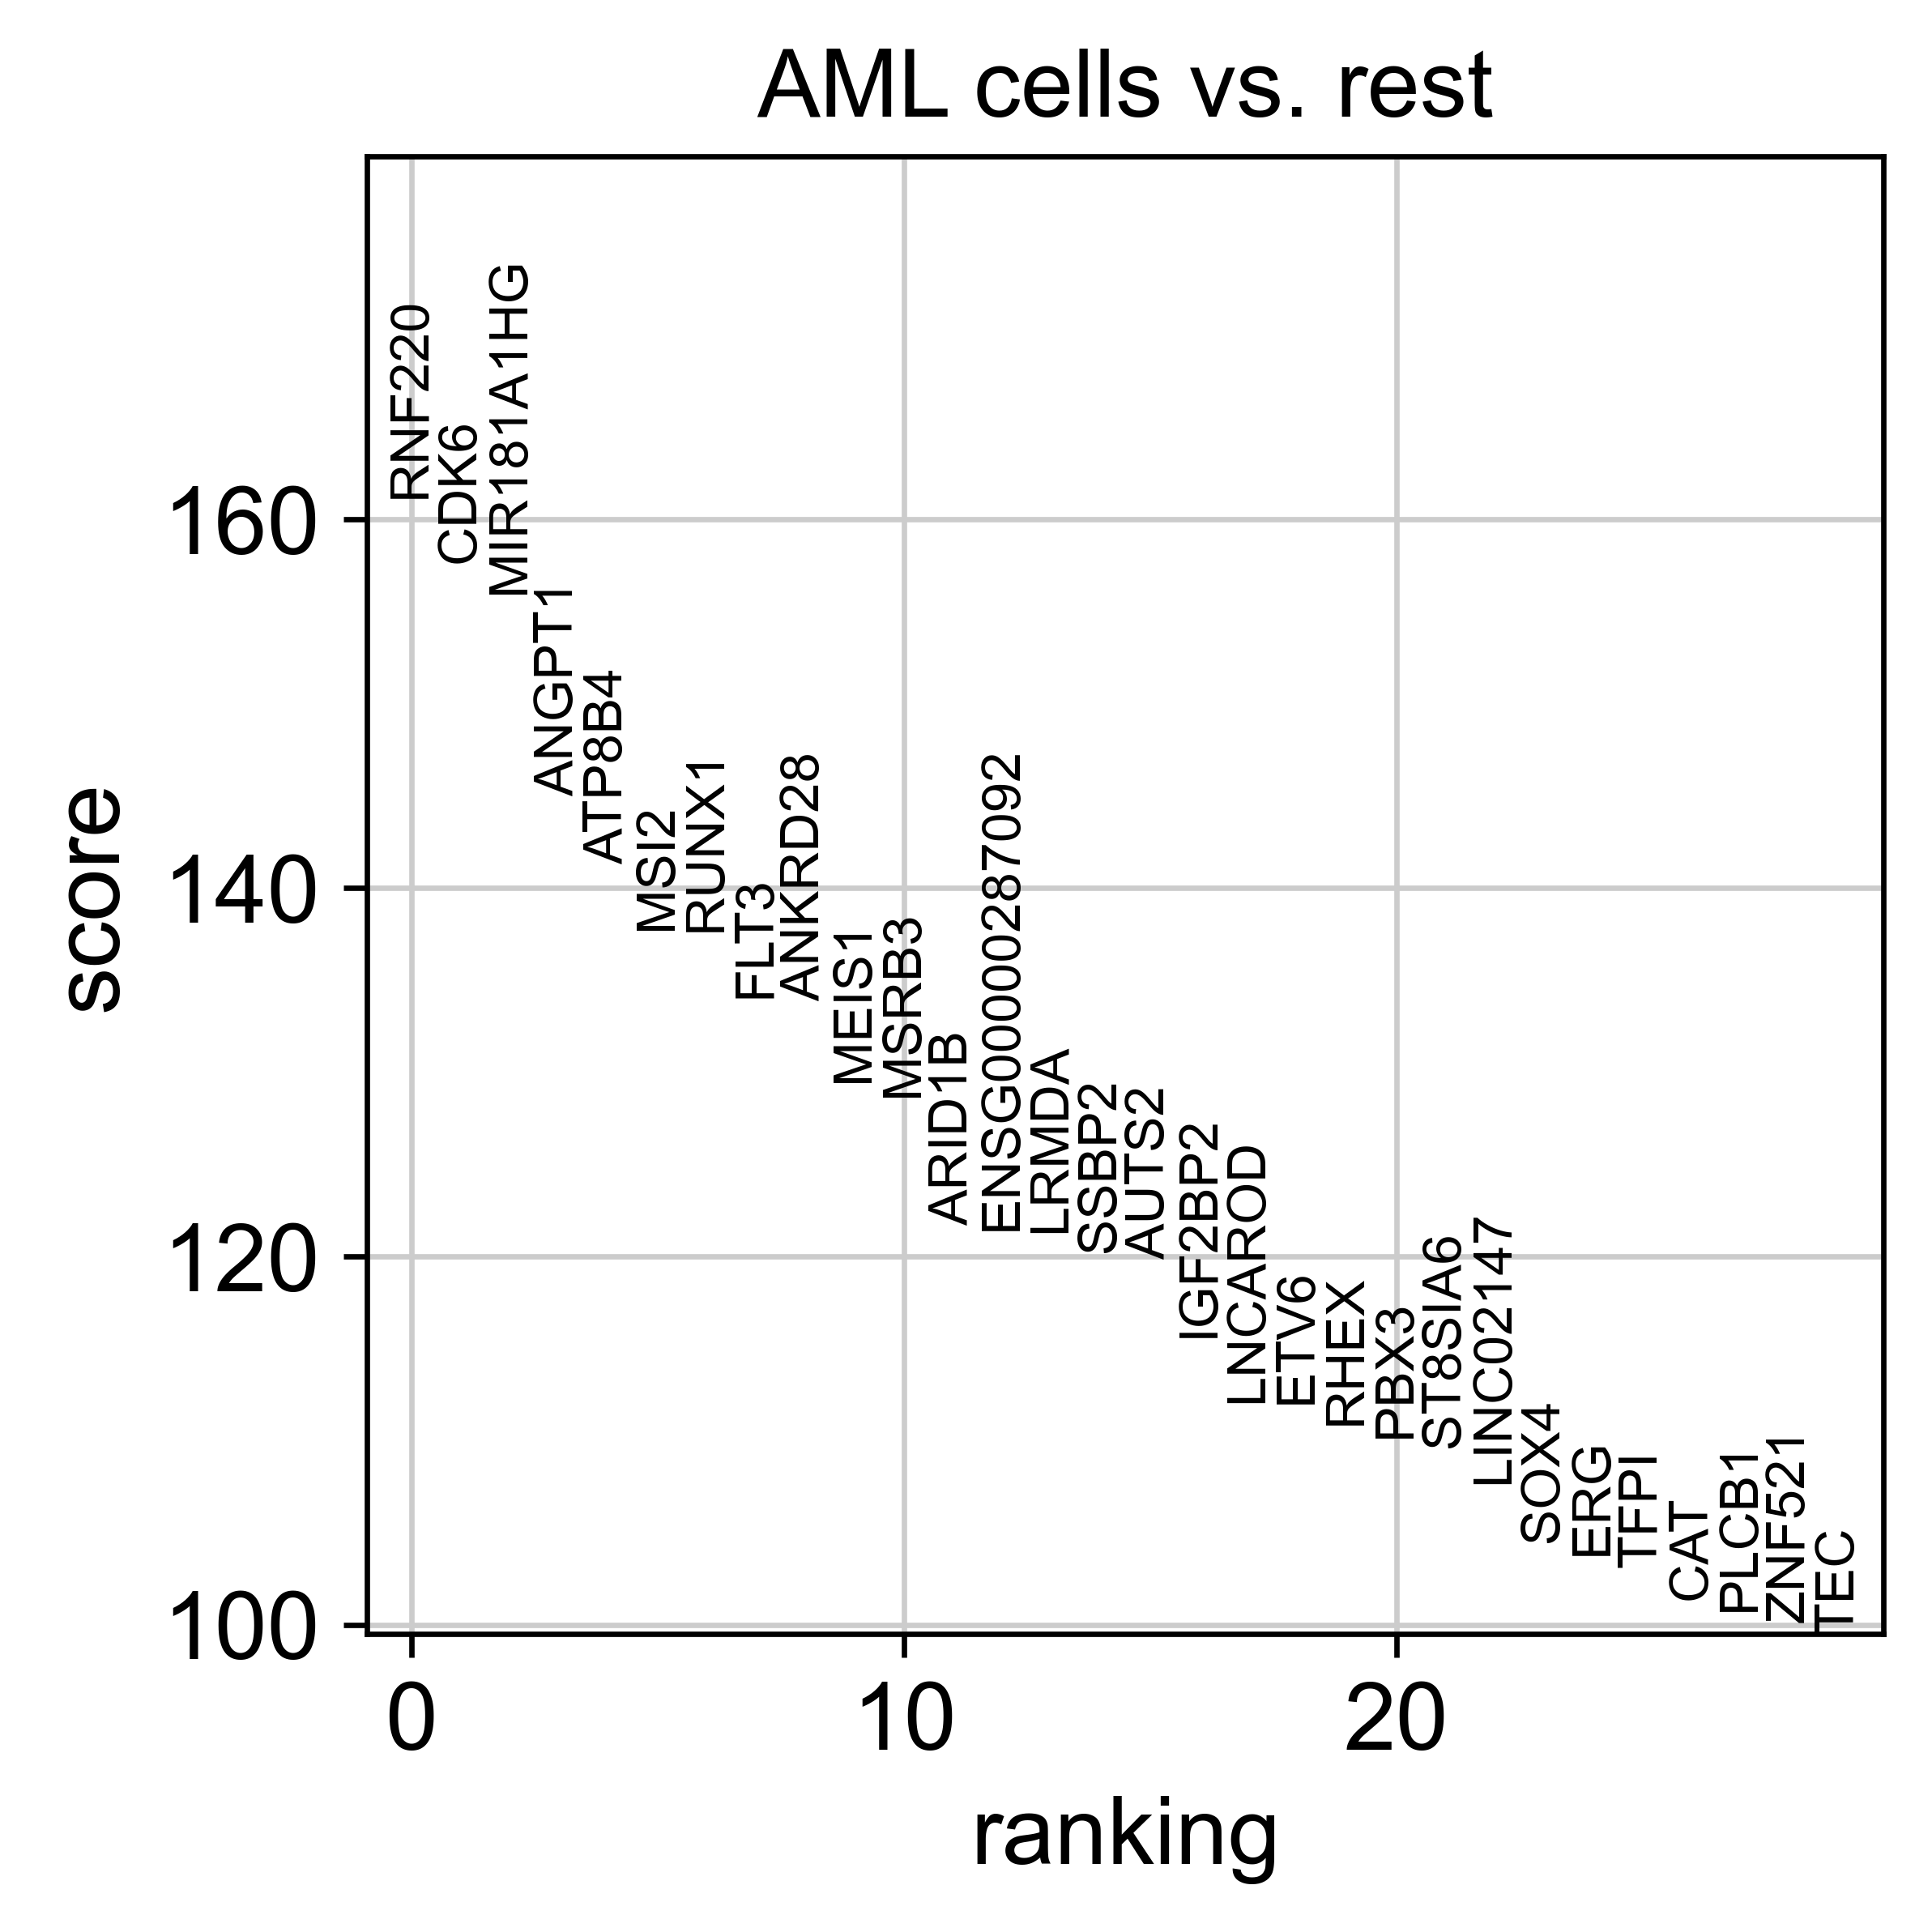

In [16]:
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False, ax=ax, show = False)

In [19]:
all_aml_dge_df = sc.get.rank_genes_groups_df(adata, group="AML cells")
all_aml_dge_df

,names,scores,logfoldchanges,pvals,pvals_adj
0,RNF220,161.189804,6.172104,0.0,0.0
1,CDK6,157.689621,5.274713,0.0,0.0
2,MIR181A1HG,155.993393,5.664346,0.0,0.0
3,ANGPT1,144.987289,6.154223,0.0,0.0
4,ATP8B4,141.325287,4.653110,0.0,0.0
...,...,...,...,...,...
20604,PTPRJ,-90.714035,-4.820098,0.0,0.0
20605,HLA-B,-92.799759,-2.488866,0.0,0.0
20606,FYB1,-94.110512,-2.430524,0.0,0.0
20607,PTPRC,-112.953926,-1.636508,0.0,0.0


In [25]:
all_aml_dge_df.to_csv("dge/final/aml_cells_vs_rest_only_abund_5cells_10counts.csv")

all_aml_dge_df[all_aml_dge_df["pvals_adj"] < 0.05].sort_values(by = "scores", ascending=False).to_excel("dge/final/aml_cells_vs_rest_filtered_by_padj_sorted_by_score_only_abund_5cells_10counts.xlsx")

all_aml_dge_df_sorted = all_aml_dge_df.copy()
all_aml_dge_df_sorted[all_aml_dge_df_sorted["pvals_adj"] < 0.05].sort_values(by = "logfoldchanges", ascending=False).to_excel("dge/final/aml_cells_vs_rest_filtered_by_padj_sorted_by_fc_only_abund_5cells_10counts.xlsx")

